In [3]:
from Datasets import CountceptionPickleDataset, CountceptionRawDataset
from matplotlib import pyplot as plt
from Models import CountCeptionModel
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torch.utils.data import random_split
import numpy as np
from skimage.io import imread
import torchvision.transforms as transforms
import torch

In [ ]:
# Load dataset
dataset = CountceptionRawDataset("C:/Users/gator/FullerLab/BrainStemSegmenter/Data_10-28-2022/cropped")

In [18]:
# Load Model
model = CountCeptionModel()
# model = model.load_from_checkpoint("C:/Users/gator/FullerLab/BrainStemSegmenter/lightning_logs/version_21/checkpoints/epoch=435-step=18748 copy.ckpt")
model = model.load_from_checkpoint("C:/Users/gator/FullerLab/BrainStemSegmenter/lightning_logs/version_30/checkpoints/epoch=869-step=13920.ckpt")
model.eval()
# model = model.to(torch.device("cuda"))

In [19]:
image_path = "C:/Users/gator/FullerLab/BrainStemSegmenter/Data_10-28-2022/1sAc1r2 PM NEUN.tif"
image = imread(image_path)
tensor_img = [transforms.ToTensor()(image)]
tensor_img = torch.stack(tensor_img)
# tensor_img = torch.stack(tensor_img).cuda()

In [20]:
pred = model.forward(tensor_img)
# pred = model.forward(tensor_img).cpu()
pred = pred[0].detach().permute(1,2,0)

RuntimeError: CUDA out of memory. Tried to allocate 464.00 MiB (GPU 0; 8.00 GiB total capacity; 6.43 GiB already allocated; 0 bytes free; 6.45 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [16]:
# Count cells
patch_size = 32
ef = ((patch_size / 1) ** 2.0)
output_count = (pred.numpy()[1000:2000,1000:2000] / ef).sum(axis=(1, 2))[0]
print(output_count)

0.24002889


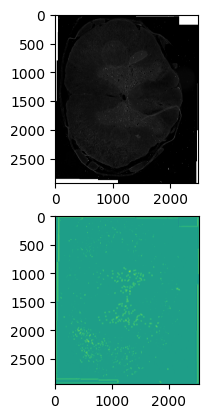

In [12]:
f, axarr = plt.subplots(2,1)
axarr[0].imshow(image)
axarr[1].imshow(pred)
plt.show()